<a href="https://colab.research.google.com/github/MuhammadIeyan/Heat_Conduction_Solver/blob/main/Heat_Conduction_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview

This project implements a numerical solution for 1D steady-state heat conduction with uniform heat generation using the Finite Volume Method (FVM). The solver determines the temperature distribution across a plane wall subject to asymmetric boundary conditions: convection on one side and a constant heat flux on the other.

This simulation compares the numerical approximation against the exact analytical solution to validate accuracy and performs a mesh sensitivity analysis to demonstrate convergence.

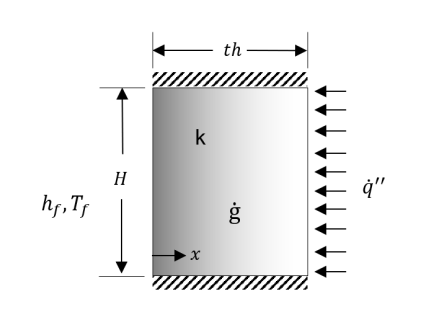

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Input variables
th = 0.75           # Thickness of the wall [m]
H = 1.5             # Height of the wall [m]
W = 1.0             # Width of the wall [m]
k = 40.0            # Thermal conductivity [W/m-K]
g_dot = 5 * 10**4   # Volumetric heat generation [W/m^3]
q_flux = 100.0      # Uniform heat flux [W/m^2] (Entering the wall)
h_f = 200.0         # Convection Heat Transfer coefficient [W/m^2-K]
T_f_C = 20.0        # Fluid Temperature [C]
T_f = T_f_C + 273.15 # Fluid Temperature [K]

In [4]:
# NUMERICAL VS ANALYTICAL (N=101)

N = 101
x = np.linspace(0, th, N)
delta_x = th / (N - 1)

# 1. Numerical Solution Setup
A = np.zeros((N, N))
b = np.zeros(N)

# -- Node 0: Left Boundary (Convection) --
# Energy Balance: h(Tf - T0) + k(T1 - T0)/dx + g*dx/2 = 0
A[0, 0] = h_f * delta_x + k
A[0, 1] = -k
b[0] = h_f * delta_x * T_f + g_dot * (delta_x**2) / 2

# -- Internal Nodes (1 to N-2) --
for i in range(1, N - 1):
    A[i, i - 1] = 1
    A[i, i]     = -2
    A[i, i + 1] = 1
    b[i]        = -(g_dot * delta_x**2) / k

# -- Node N-1: Right Boundary (Heat Flux IN) --
# Energy Balance: k(T_{N-2} - T_{N-1})/dx + q_flux + g*dx/2 = 0
A[N-1, N-2] = -k
A[N-1, N-1] = k
b[N-1]      = q_flux * delta_x + g_dot * (delta_x**2) / 2

# Solve System
T_num_K = np.linalg.solve(A, b)
T_num_C = T_num_K - 273.15 # Convert to Celsius

# C1 derivation based on BC: -k*dT/dx|_L = -q_flux (flux in)
C1 = (q_flux + g_dot * th) / k
# C2 derivation based on BC: -k*dT/dx|_0 = h(Tf - T(0))
C2 = T_f + (k * C1) / h_f

T_ana_K = -(g_dot / (2 * k)) * x**2 + C1 * x + C2
T_ana_C = T_ana_K - 273.15 # Convert to Celsius

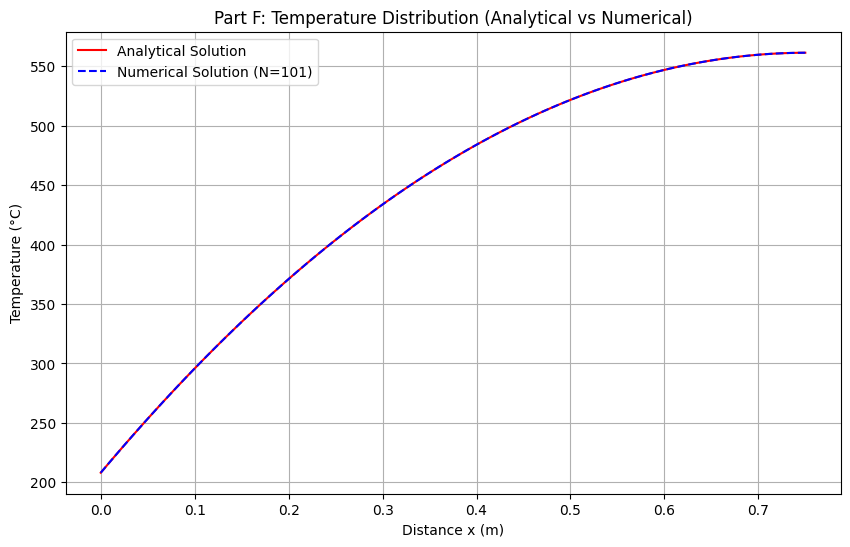

In [5]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, T_ana_C, 'r-', linewidth=1.5, label='Analytical Solution')
plt.plot(x, T_num_C, 'b--', linewidth=1.5, label='Numerical Solution (N=101)')
plt.xlabel("Distance x (m)")
plt.ylabel("Temperature (°C)")
plt.title("Part F: Temperature Distribution (Analytical vs Numerical)")
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [9]:
N_values = np.arange(3, 102)
T_max_values = []
x_max_values = []
x_max_interp = []

for N_loop in N_values:
    dx_loop = th / (N_loop - 1)
    x_loop = np.linspace(0, th, N_loop)

    A_loop = np.zeros((N_loop, N_loop))
    b_loop = np.zeros(N_loop)

    A_loop[0, 0] = h_f * dx_loop + k
    A_loop[0, 1] = -k
    b_loop[0]    = h_f * dx_loop * T_f + g_dot * (dx_loop**2) / 2

    # Internal
    for i in range(1, N_loop - 1):
        A_loop[i, i - 1] = 1
        A_loop[i, i]     = -2
        A_loop[i, i + 1] = 1
        b_loop[i]        = -(g_dot * dx_loop**2) / k

    # BC 2 (Right)
    A_loop[N_loop-1, N_loop-2] = -k
    A_loop[N_loop-1, N_loop-1] = k
    b_loop[N_loop-1]           = q_flux * dx_loop + g_dot * (dx_loop**2) / 2

    # Solve
    T_loop_K = np.linalg.solve(A_loop, b_loop)
    T_loop_C = T_loop_K - 273.15

    # --- FIND MAX (Standard) ---
    idx_max = np.argmax(T_loop_C)
    T_max_values.append(T_loop_C[idx_max])
    x_max_values.append(x_loop[idx_max]) # The "Jagged" value

    # --- FIND MAX (Interpolated for Smoothness) ---
    # We fit a parabola to the max node and its neighbors
    if 0 < idx_max < N_loop - 1:
        # Get x and T for i-1, i, i+1
        x_L, x_M, x_R = x_loop[idx_max-1], x_loop[idx_max], x_loop[idx_max+1]
        T_L, T_M, T_R = T_loop_C[idx_max-1], T_loop_C[idx_max], T_loop_C[idx_max+1]

        # Formula for vertex of parabola given 3 points
        denom = (T_L - 2*T_M + T_R)
        if denom != 0:
            offset = 0.5 * ((T_L - T_R) / denom) * dx_loop
            x_smooth = x_M + offset
        else:
            x_smooth = x_M
    else:
        x_smooth = x_loop[idx_max]

    x_max_interp.append(x_smooth)

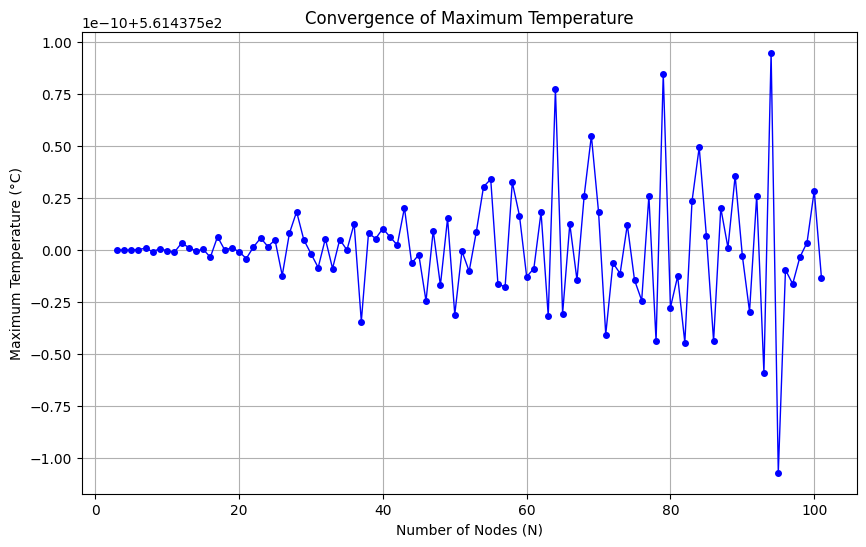

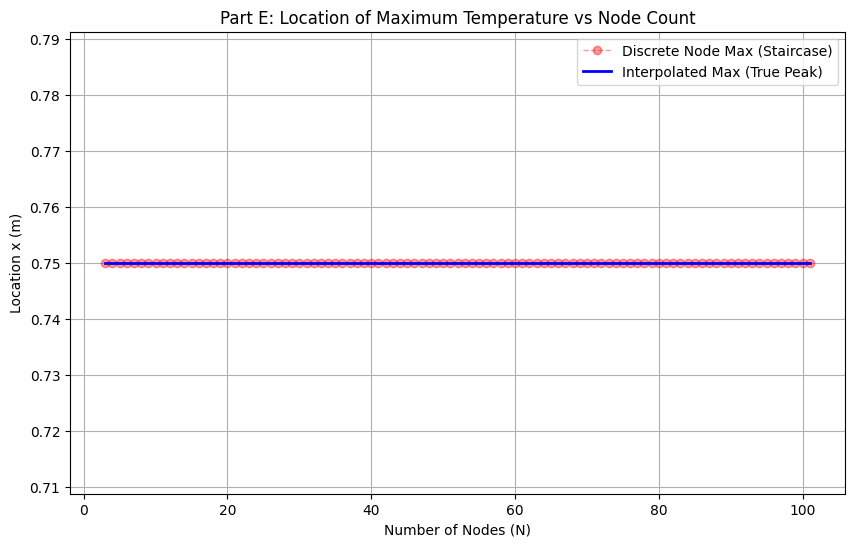

In [10]:
# Max Temp vs N
plt.figure(figsize=(10, 6))
plt.plot(N_values, T_max_values, 'bo-', linewidth=1, markersize=4)
plt.xlabel("Number of Nodes (N)")
plt.ylabel("Maximum Temperature (°C)")
plt.title("Convergence of Maximum Temperature")
plt.grid(True)
plt.show()

# Location of Max Temp vs N
plt.figure(figsize=(10, 6))
plt.plot(N_values, x_max_values, 'ro--', alpha=0.4, linewidth=1, label='Discrete Node Max (Staircase)')
plt.plot(N_values, x_max_interp, 'b-', linewidth=2, label='Interpolated Max (True Peak)')
plt.xlabel("Number of Nodes (N)")
plt.ylabel("Location x (m)")
plt.title("Part E: Location of Maximum Temperature vs Node Count")
plt.legend()
plt.grid(True)
plt.show()